In [22]:
import sympy as sym 
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap, BoundaryNorm

In [23]:
class Swizzle:
    
  BitAnd = sym.Function('BitAnd')
  BitOr  = sym.Function('BitOr')
  BitXor = sym.Function('BitXor')
  RShift = sym.Function('RShift')
  LShift = sym.Function('LShift')
  BitNot = sym.Function('BitNot')
  Max = sym.Max
  Min = sym.Min

  def __init__(self, m_base: int, b_bits: int, s_shift: int, N_elems: int):
      
    assert m_base >= 0 
    assert b_bits >= 0 
    assert abs(s_shift) >= b_bits 
    self.N_elems = N_elems
    
    self.m_base = sym.Integer(m_base)
    self.b_bits = sym.Integer(b_bits)
    self.s_shift = sym.Integer(s_shift)
    
    self.b = sym.Symbol('b', integer=True) 
    self.m = sym.Symbol('m', integer=True)
    self.s = sym.Symbol('s', integer=True)
    self.x = sym.Symbol('x', integer=True)

    LShift, BitAnd, BitOr = Swizzle.LShift, Swizzle.BitAnd, Swizzle.BitOr
    BitXor, RShift = Swizzle.BitXor, Swizzle.RShift
    Max, Min = Swizzle.Max, Swizzle.Min

    one = sym.Integer(1) 
    zero = sym.Integer(0)

    base_mask = (LShift(one, self.b)) - 1
    src_shift = self.m + Max(zero, self.s)
    dst_shift = self.m - Min(zero, self.s)
    
    src_mask = LShift(base_mask, src_shift) 
    dst_mask = LShift(base_mask, dst_shift)
    
    bits_to_move = BitAnd(self.x, src_mask)
    
    self.swizzle_mask = BitOr(src_mask, dst_mask)
    
    expr_pos_s = BitXor(self.x, RShift(bits_to_move, self.s))
    expr_neg_s = BitXor(self.x, LShift(bits_to_move, -self.s))

    self.swizzle_map_sym = sym.Piecewise(
        (expr_pos_s, self.s >= 0),
        (expr_neg_s, True)
    )
    self.swizzle_map = self._substitute(self.swizzle_map_sym, (self.m_base, self.b_bits, self.s_shift), (self.m, self.b, self.s))
    self.realized_swizzle_map = "un_realized"
    

  def __repr__(self):
    return (
        f"Swizzle(\n"
        f"  symbols = ({self.b}, {self.m}, {self.s}, {self.x}),\n"
        f"  mask    = {self.swizzle_mask},\n"
        f"  map     = {self.swizzle_map_sym}\n"
        f")"
    )
      
  def _get_realization_map(self):
    import numpy as np
    return {
        'BitAnd': np.bitwise_and,
        'BitOr':  np.bitwise_or,
        'BitXor': np.bitwise_xor,
        'RShift': np.right_shift,
        'LShift': np.left_shift,
        'BitNot': np.invert,
        'Max':    np.maximum,
        'Min':    np.minimum
    }
  
  def _substitute (self, expr: sym.Expr, new_symbols: Tuple[sym.Expr,...], old_symbols: Tuple[sym.Expr,...]): 
    new_expr = expr 
    for i in range(len(new_symbols)): 
      new_expr = new_expr.subs(old_symbols[i], new_symbols[i])
      
    return new_expr
  
  def realize(self):
    ops = self._get_realization_map()
    func_lamb = sym.lambdify(
            self.x, 
            self.swizzle_map, 
            modules=['numpy', ops]
        )
    arr = np.arange(self.N_elems)
    self.realized_swizzle_map = func_lamb(arr)

In [24]:
class Layout: 
  def __init__ (self, shape: Tuple[int,...], stride: Tuple[int,...], 
                kind: str):
    
    assert len(shape) == len(stride) 
    self.m = len(shape)
    self.shape_int = shape
    self.stride_int = stride
    self.shape = tuple([sym.Integer(shape[i]) for i in range(self.m)])
    self.stride = tuple([sym.Integer(stride[i]) for i in range(self.m)])
    self.S = tuple([sym.Symbol(f"S_{str(i)}") for i in range(self.m)])
    self.S_S = [sym.Integer(1)]*self.m
    self.D = tuple([sym.Symbol(f"D_{str(i)}") for i in range(self.m)])
    self.I = sym.Symbol("x")
    self.N_elems = 1 
    for i in range(self.m): 
      self.N_elems *= shape[i]
      
    
    for i in range(1,self.m): 
      self.S_S[i] = self.S[i-1]*self.S_S[i-1]
      
    self.S_S = tuple(self.S_S)  
    

    self.fan_out = [0]*self.m 
    for i in range(self.m): 
      self.fan_out[i] = (self.I // self.S_S[i]) % self.S[i]
    
    self.fan_out = tuple(self.fan_out)
    
    self.fan_in = sym.Integer(0) 
    self.fan_out_sym = tuple([sym.Symbol(f"y_{str(i)}") for i in range(self.m)])
    for i in range(self.m):
      self.fan_in += self.D[i]*self.fan_out_sym[i]
      
    self.layout_sym = self._substitute(self.fan_in, self.fan_out, self.fan_out_sym)
    self.layout = self._substitute(self.layout_sym, self.shape, self.S)
    self.layout = self._substitute(self.layout, self.stride, self.D)
    self.realized_layout = "un_realized"
    
    
  
  def _substitute (self, expr: sym.Expr, new_symbols: Tuple[sym.Expr,...], old_symbols: Tuple[sym.Expr,...]): 
    new_expr = expr 
    for i in range(len(new_symbols)): 
      new_expr = new_expr.subs(old_symbols[i], new_symbols[i])
      
    return new_expr
  
  def realize(self): 
    one_d_domain = np.arange(self.N_elems) 
    layout_lambda = sym.lambdify([self.I], self.layout, "numpy")
    self.realized_layout = layout_lambda(one_d_domain).astype(int)
    

In [25]:
def expand(layout, n_elems_per_vector, n_bytes_per_elem): 
  g = n_elems_per_vector * n_bytes_per_elem
  layout_to_bytes = np.zeros((np.size(layout),g)).astype(int)
  for i in range(g):
    layout_to_bytes[:,i] = g*layout + i 
    
  return layout_to_bytes.flatten()

In [26]:
def make_swizzle(layout, n_elems_per_vector, n_bytes_per_elem,
                 b_bits, m_base, s_shift):

    layout.realize()
    layout_arr = layout.realized_layout

    # element → byte expansion
    exp_layout_arr = expand(layout_arr, n_elems_per_vector, n_bytes_per_elem)

    ATOM_BYTES = n_elems_per_vector * n_bytes_per_elem
    N = np.max(exp_layout_arr) + 1

    # build + realize swizzle
    swizzler = Swizzle(m_base, b_bits, s_shift, N)

    # legality: swizzle must not touch intra-atom bits
    assert m_base >= int(np.log2(ATOM_BYTES))

    swizzler.realize()
    s_map = swizzler.realized_swizzle_map

    # apply swizzle on byte addresses
    swizzled_layout_arr = s_map[exp_layout_arr]

    # collapse back: take first byte of each atom
    swizzled_elem_arr = swizzled_layout_arr.flatten()[::ATOM_BYTES] // ATOM_BYTES

    # --- bank grouping ---
    banks_per_vec_word = ATOM_BYTES // 4
    n_bank_groups = 32 // banks_per_vec_word

    # reshape colexical (CUTLASS-style)
    orig_atoms = layout_arr.reshape(layout.shape_int, order="F")
    swiz_atoms = swizzled_elem_arr.reshape(layout.shape_int, order="F")

    # bank-group coloring
    orig_groups = orig_atoms % n_bank_groups
    swiz_groups = swiz_atoms % n_bank_groups

    return orig_atoms, swiz_atoms, orig_groups, swiz_groups

  

  


In [27]:
def draw_layout(arr, title="Layout", cmap="viridis"):
    """
    Draw a 2D layout array as a heatmap + value table.

    Parameters
    ----------
    arr : np.ndarray (2D)
        Integer layout map (e.g. swizzled layout)
    title : str
        Plot title
    cmap : str
        Matplotlib colormap name
    """

    import numpy as np
    import matplotlib.pyplot as plt

    assert arr.ndim == 2, "draw_layout only supports 2D arrays"

    H, W = arr.shape

    plt.figure(figsize=(W * 0.8, H * 0.8))

    # Heatmap background
    plt.imshow(arr, cmap=cmap)

    # Annotate each cell with its integer value
    for i in range(H):
        for j in range(W):
            plt.text(
                j, i,
                str(arr[i, j]),
                ha="center", va="center",
                color="white" if arr[i, j] > arr.max() * 0.5 else "black",
                fontsize=9
            )

    # Axes formatting
    plt.xticks(range(W))
    plt.yticks(range(H))
    plt.xlabel("col")
    plt.ylabel("row")
    plt.title(title)

    plt.colorbar(label="Address Value")

    plt.show()


In [28]:
layout = Layout((8,8),(8,1), "na")
b_bits = 3 
m_base = 4
s_shift = 3 
n_bytes_per_elem = 4
n_elems_per_vector = 4 

no_swiz,swiz, no_swiz_bank, swiz_bank = make_swizzle(layout,n_elems_per_vector, n_bytes_per_elem, b_bits, m_base,s_shift)

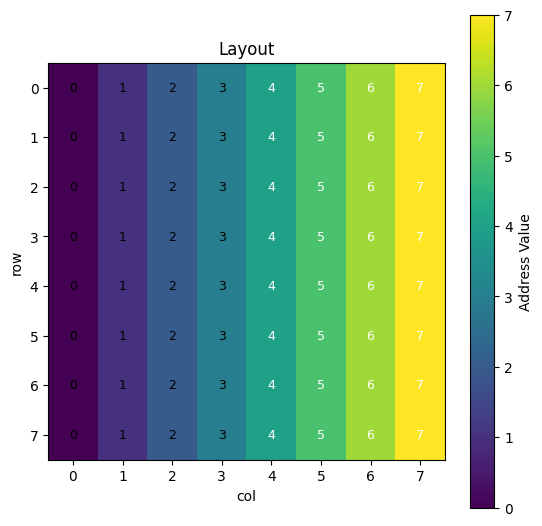

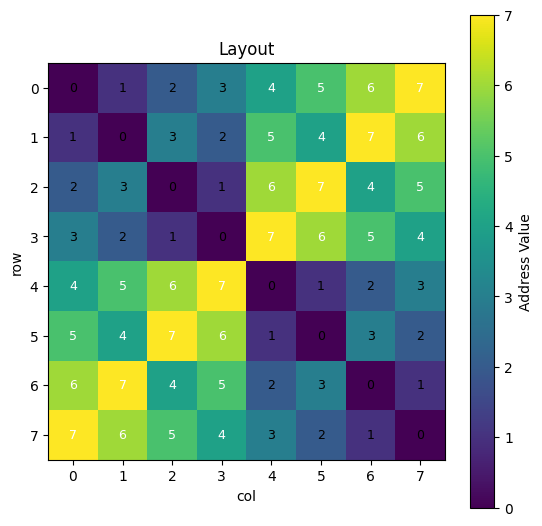

In [32]:
draw_layout(no_swiz_bank)
draw_layout(swiz_bank)

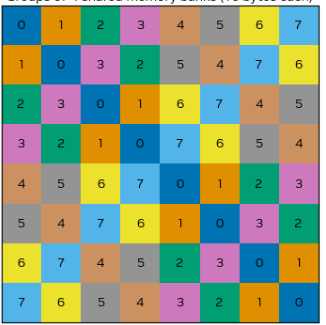